In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.4 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 20.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/kanjis2radicals")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset kanjis2radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___kanjis2radicals/default/0.0.0/2a901dcb0c8c5fb29e2cbaf02572500ee7edf015d8a43288a286645943923f03. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
ds['train'].features

{'kanji_image': Image(decode=True, id=None),
 'meta': {'id': Value(dtype='int32', id=None),
  'characters': Value(dtype='string', id=None),
  'meanings': Value(dtype='string', id=None),
  'radicals': Sequence(feature={'characters': Value(dtype='string', id=None), 'id': Value(dtype='int32', id=None), 'slug': Value(dtype='string', id=None)}, length=-1, id=None)}}

In [4]:
ds['train'][0]

{'kanji_image': <PIL.PngImagePlugin.PngImageFile image mode=L size=100x100 at 0x7F15995932E0>,
 'meta': {'id': 440,
  'characters': '一',
  'meanings': 'One,1',
  'radicals': {'characters': ['一'], 'id': [1], 'slug': ['ground']}}}

In [5]:
radical_ids = set()
for meta in ds['train']['meta']:
    for id in meta['radicals']['id']:
        radical_ids.add(id)

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [6]:
import numpy as np

def one_hot_encode(example):
    radical_indices = [radical_id_to_index[id] for id in example["meta"]["radicals"]["id"]]
    one_hot = np.zeros(len(unique_radical_ids))
    one_hot[radical_indices] = 1
    return {"labels": one_hot}

In [7]:
ds_one_hot = ds.map(one_hot_encode)

Map:   0%|          | 0/2027 [00:00<?, ? examples/s]

In [8]:
ds_train = ds_one_hot.remove_columns(["meta"])

In [32]:
import random

def random_rotate_image(image):
    angle = random.choice([0, 90, 180, 270])
    return image.rotate(angle)

In [33]:
from datasets import Dataset
rotated_samples = []

angles = [0, 90, 180, 270]

for i in range(len(ds_train['train'])):
    example = ds_train['train'][i].copy()
    rotated_samples.append(example)
    for i in range(len(angles)):
        rotated_example = example.copy()
        rotated_example['kanji_image'] = example['kanji_image'].rotate(angles[i])
        rotated_samples.append(rotated_example)


In [54]:
import pandas as pd
rotated_ds = Dataset.from_dict(pd.DataFrame(rotated_samples))

In [9]:
from PIL import Image

resized_ds = ds_train.map(lambda example: {"kanji_image": example["kanji_image"].resize((224, 224), Image.ANTIALIAS)})

Map:   0%|          | 0/2027 [00:00<?, ? examples/s]

In [10]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor()

dataset = resized_ds.map(lambda example: {'kanji_image': processor(example['kanji_image'].convert('RGB'))['pixel_values'][0]})

Map:   0%|          | 0/2027 [00:00<?, ? examples/s]

In [24]:
import numpy as np
np.array(dataset['train'][0]['kanji_image']).shape

(3, 224, 224)

In [25]:
splits = dataset['train'].train_test_split(test_size=0.1)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 6 * 6, 1024) 
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        return x

num_classes = len(unique_radical_ids)
model = ImprovedCNN(num_classes)

In [13]:
import torch
from transformers import ViTForImageClassification

class ViTForMultiLabelClassification(ViTForImageClassification):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:, 0])

        # Apply sigmoid activation for multi-label classification
        logits = torch.sigmoid(logits)

        return logits

In [14]:
from transformers import ViTConfig, ViTModel

model_name = "google/vit-base-patch16-224"
config = ViTConfig.from_pretrained(model_name)
vit_model = ViTModel.from_pretrained(model_name, config=config)

num_classes = len(unique_radical_ids)
model = ViTForMultiLabelClassification(config, num_classes)
model.vit = vit_model

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
from torch.utils.data import DataLoader

batch_size = 32

splits.set_format(type='torch', columns=['kanji_image', 'labels'])
train_loader = DataLoader(splits['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(splits['test'], batch_size=batch_size, shuffle=False)

In [27]:
import torch
import torch.nn as nn

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
train_loader.dataset[0]['kanji_image'].shape

torch.Size([224, 224])

In [30]:
losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for idx, batch in enumerate(train_loader):
        images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if idx % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {test_loss/len(test_loader)}")

Epoch 1/10, Step 1/57, Loss: 0.7234492897987366
Epoch 1/10, Step 21/57, Loss: 0.02783675491809845
Epoch 1/10, Step 41/57, Loss: 0.03024142049252987
Epoch 1/10, Train Loss: 0.0618944547482227, Val Loss: 0.028572415400828634
Epoch 2/10, Step 1/57, Loss: 0.027078771963715553
Epoch 2/10, Step 21/57, Loss: 0.028765110298991203
Epoch 2/10, Step 41/57, Loss: 0.026305703446269035
Epoch 2/10, Train Loss: 0.02771194161553132, Val Loss: 0.02864031307399273
Epoch 3/10, Step 1/57, Loss: 0.02642020583152771


KeyboardInterrupt: 

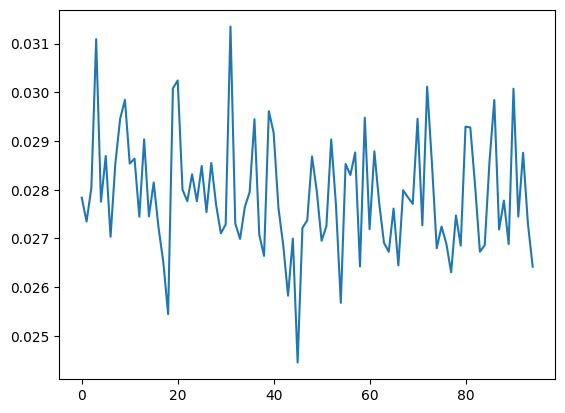

In [35]:
import matplotlib.pyplot as plt

plt.plot(losses[20:])
plt.show()

In [36]:
import numpy as np
from sklearn.metrics import f1_score

threshold = 0.05

model.eval()
all_ground_truth = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        image, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        outputs = model(image)
        bool_outputs = (outputs > threshold).cpu().numpy()
        all_predictions.extend(bool_outputs)
        
        all_ground_truth.extend(labels.cpu().numpy())

y_true = np.array(all_ground_truth)
y_pred = np.array(all_predictions)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

for i in range(10):
    print("Ground Truth:", np.where(y_true[i] == 1)[0])
    print("Predictions:", np.where(y_pred[i] == 1)[0])
    print()

F1 Score: 0.008282986893226162
Ground Truth: [342]
Predictions: [15 21 74 99]

Ground Truth: [ 67  71  86 112]
Predictions: [15 21 74 99]

Ground Truth: [ 33  99 440]
Predictions: [15 21 74 99]

Ground Truth: [ 89  99 110]
Predictions: [15 21 74 99]

Ground Truth: [71 91]
Predictions: [15 21 74 99]

Ground Truth: [18 33]
Predictions: [15 21 74 99]

Ground Truth: [137 200]
Predictions: [15 21 74 99]

Ground Truth: [36 60 66]
Predictions: [15 21 74 99]

Ground Truth: [19 47 57 95]
Predictions: [15 21 74 99]

Ground Truth: [  0  99 434]
Predictions: [15 21 74 99]



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
